In [48]:
import pandas as pd
import numpy as np
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Завантаження даних
base_path = '/content/drive/MyDrive/test-task-for-ds-time-series-forecasting-2025-03/'
df = pd.read_csv(base_path + 'ts_hist.csv', parse_dates=['date'])

print("Форма датафрейму:", df.shape)
print("Колонки:", df.columns.tolist())
print("\nДіапазон дат:", df['date'].min(), "→", df['date'].max())
print(df.head())

# Додаємо початок тижня
df['week_start'] = df['date'] - pd.to_timedelta(df['date'].dt.weekday, unit='D')

# Агрегація до тижня
weekly = (
    df.groupby(['store_id', 'dept_id', 'item_id', 'week_start'], as_index=False)
    .agg({'qnt': 'sum'})
)

# Створюємо правильний unique_id (формат як у submission)
weekly['unique_id'] = weekly.apply(
    lambda row: f"{row['store_id']}_{row['dept_id']}_{row['item_id']}", axis=1
)

# Логарифмічна трансформація
weekly['y'] = np.log1p(weekly['qnt'])

# Розділення train/valid
train_cutoff = pd.to_datetime('2016-05-08')
train_df = weekly[weekly['week_start'] <= train_cutoff].copy()

# Підготовка train_statsforecast.csv
train_statsforecast = train_df[['unique_id', 'week_start', 'y']].copy()
train_statsforecast.rename(columns={'week_start': 'ds'}, inplace=True)

# Збереження
train_statsforecast.to_csv('train_statsforecast.csv', index=False)

print("train_statsforecast.csv готовий.")
print(train_statsforecast.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Форма датафрейму: (239511, 11)
Колонки: ['date', 'index', 'store_id', 'cat_id', 'dept_id', 'item_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'qnt']

Діапазон дат: 2014-01-01 00:00:00 → 2016-05-15 00:00:00
        date        index  store_id cat_id  dept_id  item_id event_name_1  \
0 2014-01-01  0_FOODS_1_0         0  FOODS  FOODS_1        0      NewYear   
1 2014-01-02  0_FOODS_1_0         0  FOODS  FOODS_1        0          NaN   
2 2014-01-03  0_FOODS_1_0         0  FOODS  FOODS_1        0          NaN   
3 2014-01-04  0_FOODS_1_0         0  FOODS  FOODS_1        0          NaN   
4 2014-01-05  0_FOODS_1_0         0  FOODS  FOODS_1        0          NaN   

  event_type_1 event_name_2 event_type_2  qnt  
0     National          NaN          NaN   23  
1          NaN          NaN          NaN   28  
2          NaN          NaN       

In [51]:
import pandas as pd
import numpy as np
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS

# Завантаження
train_df = pd.read_csv('train_statsforecast.csv')
submission_template = pd.read_csv('/content/drive/MyDrive/test-task-for-ds-time-series-forecasting-2025-03/ts_submission.csv')

train_df['ds'] = pd.to_datetime(train_df['ds'])

# Прогноз
models = [AutoARIMA(season_length=52), AutoETS(season_length=52)]
sf = StatsForecast(models=models, freq='W', n_jobs=-1)

fcst = sf.forecast(df=train_df, h=1)

# Зворотне log1p і усереднення моделей
for model in models:
    model_name = model.__class__.__name__
    fcst[model_name] = np.expm1(fcst[model_name])

fcst['prediction'] = fcst[[model.__class__.__name__ for model in models]].mean(axis=1)

# Перевірка збігів
matches = submission_template['index'].isin(fcst['unique_id']).sum()
print(f'Збігів з прогнозом: {matches} з {submission_template.shape[0]}')

# Формування submission
submission = submission_template.merge(fcst[['unique_id', 'prediction']], left_on='index', right_on='unique_id', how='left')

print(f"Пропущених прогнозів: {submission['prediction'].isna().sum()}")

submission['prediction'].fillna(0, inplace=True)

# Збереження submission
submission[['index', 'prediction']].rename(columns={'prediction': 'y'}).to_csv('submission_statsforecast.csv', index=False)

print("✅ submission_statsforecast.csv готовий.")


/usr/local/lib/python3.11/dist-packages/statsforecast/ets.py:657: RuntimeWarning: divide by zero encountered in scalar divide
  sigma2 = np.sum(e**2) / (ny - np_ - 1)
/usr/local/lib/python3.11/dist-packages/statsforecast/ets.py:657: RuntimeWarning: divide by zero encountered in scalar divide
  sigma2 = np.sum(e**2) / (ny - np_ - 1)


✅ Збігів з прогнозом: 405 з 405
Пропущених прогнозів: 0
✅ submission_statsforecast.csv готовий.


<ipython-input-51-4a2f5af127be>:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  submission['prediction'].fillna(0, inplace=True)


In [54]:
import pandas as pd

# Load the saved submission file into a DataFrame
submission_statsforecast = pd.read_csv('submission_statsforecast.csv')

# Now you can use the head() method to view the first few rows
submission_statsforecast.head()

,index,y
0,0_FOODS_1_0,31.384339
1,0_FOODS_1_1,17.782308
2,0_FOODS_1_10,30.278752
3,0_FOODS_1_11,21.765399
4,0_FOODS_1_13,56.141410


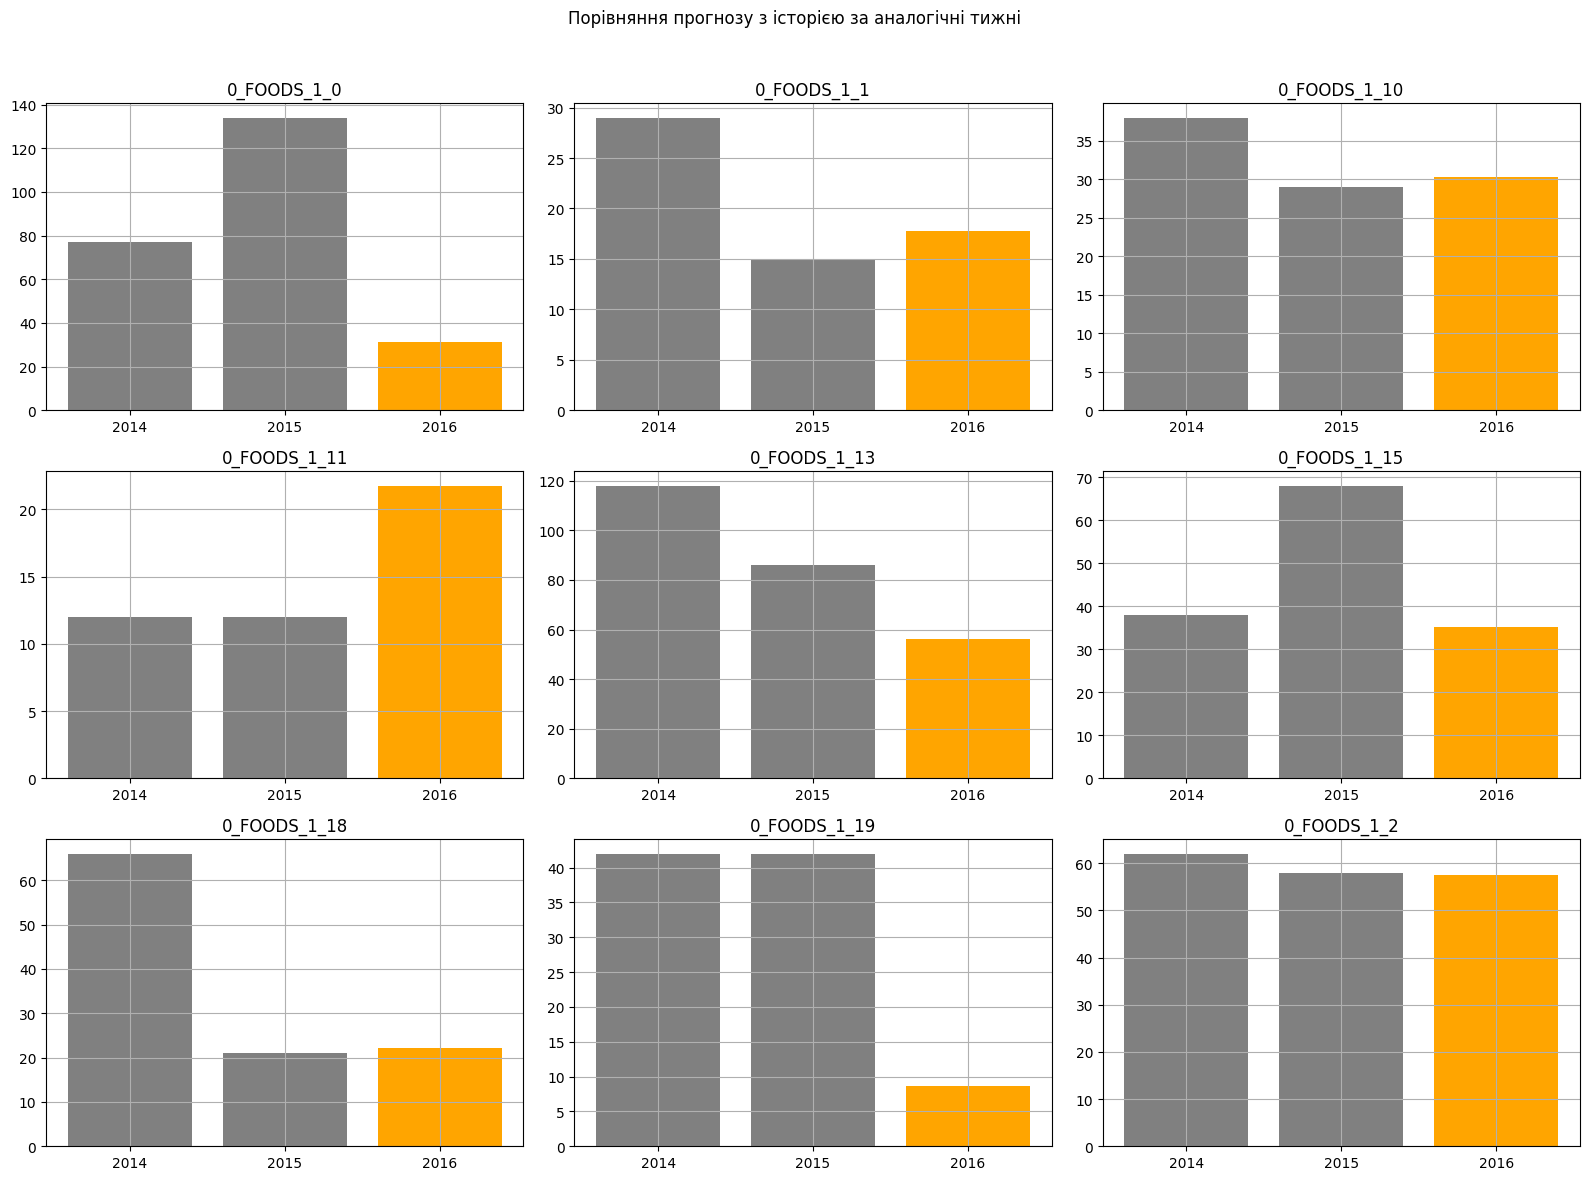

In [56]:
import matplotlib.pyplot as plt

# Завантаження історичних даних
df = pd.read_csv('/content/drive/MyDrive/test-task-for-ds-time-series-forecasting-2025-03/ts_hist.csv', parse_dates=['date'])
submission = pd.read_csv('submission_statsforecast.csv')

# Додаємо початок тижня
df['week_start'] = df['date'] - pd.to_timedelta(df['date'].dt.weekday, unit='D')

# Фільтр аналогічних періодів
periods = [
    ('2014-05-12', '2014-05-18'),
    ('2015-05-11', '2015-05-17'),
    ('2016-05-09', '2016-05-15')
]

# Агрегація
history = []
for start, end in periods[:-1]:
    mask = (df['date'] >= start) & (df['date'] <= end)
    agg = df[mask].groupby('index')['qnt'].sum().reset_index()
    agg['period'] = start[:4]
    history.append(agg)

# Прогноз
forecast = submission.copy()
forecast['period'] = '2016'
forecast.rename(columns={'y': 'qnt'}, inplace=True)

# Об'єднання
all_data = pd.concat(history + [forecast], ignore_index=True)

# Візуалізація для кількох рядів
sample_ids = all_data['index'].unique()[:9]

fig, axs = plt.subplots(3, 3, figsize=(16, 12))

for i, sample_id in enumerate(sample_ids):
    sample = all_data[all_data['index'] == sample_id]
    ax = axs[i // 3, i % 3]
    ax.bar(sample['period'], sample['qnt'], color=['gray', 'gray', 'orange'])
    ax.set_title(f'{sample_id}')
    ax.grid(True)

plt.suptitle('Порівняння прогнозу з історією за аналогічні тижні')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [58]:
from google.colab import files
files.download('submission_statsforecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Висновки

В деяких рядах (наприклад, 0_FOODS_1_10, 0_FOODS_1_1, 0_FOODS_1_11) прогноз непогано «ловить» середній рівень попередніх років.
По ряду 0_FOODS_1_2 модель прям дуже близько влучила до попередніх років. Також є ряди, де прогноз занизив рівень:
0_FOODS_1_0 — в історії по 70–140, а прогнозує лише 30.
0_FOODS_1_13, 0_FOODS_1_18, 0_FOODS_1_19 — прогноз сильно занижений.

**Причина:**

ARIMA/ETS дуже чутливі до останніх точок тренду.
Якщо в останні тижні у ряду був спад → модель прогнозує спад.
Модель не бачить «аналогічних тижнів попередніх років» → вона не знає, що в травні завжди злітає продаж, бо це логіка календаря, а не часу.

**План щодо покращення, додати:**

- Seasonal features (sin/cos month/week)
- Holiday features
- Lags & rolling mean

Вони якраз потрібні, щоб навчити модель враховувати таку сезонність, а не грубо прогнозувати з останніх значень.
